In [1]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [2]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

# ASTroCAT

Needs to be implemented:

- 

  SimpleNPZ() {
    N = addVar("nutrients","N","µM");
    P = addVar("phytoplankton","P","µM");
    P.sinks = true;
    Z = addVar("zooplankton","Z","µM");
    totalN = addGhostVar("total nitrogen","T","µM");
    
    Fuptake = addFlux("uptake","uptake", N, P);
    Fingest = addFlux("ingestion","ingest", P, Z);
    Fpmort = addFlux("P mortality","Pmort", P, N);
    Fzmort = addFlux("Z mortality","Zmort", Z, N);
    Fexcret = addFlux("excretion","excret", Z, N);

    mu0 = addParam("P max growth","mu0","1/d",2,0,2);
    ks = addParam("nutrient half-saturation","ks","µM",1, 0.1, 5);
    m = addParam("P mortality","m","1/d",0.1, 0, 0.4);
    I0 = addParam("Z max growth","I0","1/d", 3, 0, 5);
    Ks = addParam("grazing half-saturation","Ks","µM",3, 0, 4);
    epsilon = addParam("Z growth efficiency","epsilon","",0.3, 0, 1);
    mz = addParam("Z mortality","mz","1/d",0.4, 0, 1.0);
  }

  void calcFluxes() {
    for (int i=0; i<Ncells; i++) {
      Fuptake.current[i] = mu0.current * N.current[i] / (ks.current + N.current[i]) * P.current[i];
      Fingest.current[i] = I0.current * P.current[i] / (Ks.current + P.current[i]) * Z.current[i];
      Fpmort.current[i] = m.current * P.current[i];
      Fzmort.current[i] = mz.current * Z.current[i];
      Fexcret.current[i] = (1 - epsilon.current) * Fingest.current[i];
      totalN.current[i] = N.current[i] + P.current[i] + Z.current[i];
    }
  }

In [ ]:
  // the ASTroCAT ecosystem model itself.
  //
  // imposed N supply, spectrum of P, spectrum of Z, and that's it. No light dependence.
  
  Statevar Ptot, Ztot, N;
  Statevar[] P, Z;
  
  Flux[][] FgrazP; // one for each P-Z pair
  Flux[] Fegest; // summed over Z for each P
  Flux[] Fexcret; // summed over P for each Z
  Flux[] Fuptake, Fpmort, Fzmort;
  Flux Fsupply;
  
  FreeParam epsilon, fegest, supply; // system params
  FreeParam mu0, m, I0, zeta;  // rate params
  FreeParam ks, K0; // shape params
  FreeParam xpreyopt, dxprey; // grazing pref params
  float[][] phiP; // grazing preferences P -> Z
  boolean doAnnualCycle = false;
  
  int NP, NZ;

In [ ]:
    float PMinEsd = 1; // size ranges in microns
    float PMaxEsd = 20;
    
    
    // state variables
    N = addVar("nutrients","N","µM");
    P = addDiverseVarSet("phytoplankton","P","µM",NP,PMinEsd, PMaxEsd);
    Ptot = addGhostVar("total P","Ptot","µM");
    Z = addDiverseVarSet("zooplankton","Z","µM",NZ,1,2);
    for (int i=0; i<NP; i++) ((DiverseVar)Z[i]).esd = 2.16 * pow(((DiverseVar)P[i]).esd, 1.79);
    Ztot = addGhostVar("total Z","Ztot","µM");
    
    // minimum biomass values: always protect a little bit of seed stock
    for (int i=0; i<NP; i++) P[i].min = 0.01;
    for (int j=0; j<NZ; j++) Z[j].min = 0.01;
    
    // fluxes
    Fsupply = addFlux("supply","supply",null,N);
    Fuptake = addFluxSet("uptake","uptake", N, P);
    FgrazP = addFluxSet2D("grazing on P","grazP",P, Z);
    Fegest = addFluxSet("egestion","egest", Z, null);
    Fexcret = addFluxSet("excretion","excret", Z, N);
    Fpmort = addFluxSet("P mortality","Pmort", P, null);
    Fzmort = addFluxSet("Z mortality","Zmort", Z, null);

    // global params
    supply = addParam("N supply rate", "supply","µM/d", 1, 0.01, 4);
    supply.logScale = true;
    supply.highlight = true;
    FreeParam p = addParam("annual cycle on/off","annCycle","", 0, 0, 1);
    p.quantize(1);
    p.highlight = true;    
    epsilon = addParam("Z growth efficiency","epsilon","", 0.33, 0, 1);
    fegest = addParam("egestion fraction","fegest","",0.33, 0, 1); // a fraction of total grazing, not of the losses
    m = addParam("P mortality as fraction of mu0","m","", 0.1, 0, 1);
    dxprey = addParam("prey size preference width","dxprey","", 0.25, 0.01, 1);
    dxprey.logScale = true;
    
    // diverse params: defined using a scale size of 1 µm for easy reading
    // std dev within a size class is defined based on the sources cited in the astrocat paper, but not used in astrocat 1.0
    //   rate params
    mu0 = addDiverseParam("P max growth","mu0","1/d",                   2.6,     0,   3,   3.8,    1,  -0.45); // initial      min      max     std dev (*,/) within a size class      allo scale size     exponent for allometry
    I0 = addDiverseParam( "Z max grazing","I0","1/d",                    26,     0,  30,   1.9,    1,  -0.4);
    zeta = addDiverseParam("Z quadratic mortality","zeta","1/µM/d",       1,     0,  10,     1,    1,   0);
    zeta.highlight = true;
    //  functional-response shape params
    ks = addDiverseParam("nutrient half-saturation","ks","µM",          0.1,   0.1,   5,     2,    1,   1);
    K0 = addDiverseParam("grazing half-saturation","K0","µM",             3,   0.3,  30,     3,    1,   0);
    K0.logScale = true;
    //  grazing preference params
    xpreyopt = addDiverseParam("optimal prey size","xpreyopt","",      0.65,   0.5,  30,     1,    1,   0.56); // has allometry but no stochasticity; noise in prey prefs is handled separately

    phiP = new float[NP][NZ]; // prey preferences: internal array
    addParam("max preference","maxPref","", 10, 0, 10);

    p = addParam("prefs allometry on/off","prefsAllo","",1, 0, 1);
    p.quantize(1);
    p.highlight = true;
    p = addParam("other allometry on/off","otherAllo","",1, 0, 1);
    p.quantize(1);
    p.highlight = true;    
    p = addParam("prefs stochasticity","prefsRand","",0, 0, 1); // other stochasticity (in mu0, I0, for example) is omitted in this version of the model
//    p.quantize(1);

In [ ]:

  void calcFluxes() {
    for (int k=0; k<Ncells; k++) { // for each spatial cell...
      // supply
      Fsupply.current[k] = supply.current;
      if (doAnnualCycle) Fsupply.current[k] *= 0.5*(1+cos(time.current[0] * TWO_PI/365.));
      // phyto growth
      for (int i=0; i<NP; i++) {
        float mu0i = getCurrent(mu0, P[i]);
        float ksi = getCurrent(ks, P[i]);
        float nutlim = N.current[k] / (ksi + N.current[k]);
        Fuptake[i].current[k] = mu0i * nutlim * P[i].current[k];
      }
      
      // grazing
      //     assemble all diet elements
      float[][] PscaledAsFood = new float[NP][NZ];
      float[] totalFood = new float[NZ];
      for (int j=0; j<NZ; j++) {
        float K0j = getCurrent(K0, Z[j]);
        totalFood[j] = 0;
        for (int i=0; i<NP; i++) {
          PscaledAsFood[i][j] = phiP[i][j] / K0j * P[i].current[k];
          totalFood[j] += PscaledAsFood[i][j];
        }
      }
      //     initialize excretion and egestion fields
      for (int i=0; i<NP; i++) Fegest[i].current[k] = 0;
      for (int j=0; j<NP; j++) Fexcret[j].current[k] = 0;
      //     calculate fluxes
      for (int j=0; j<NZ; j++) {
        float I0j = getCurrent(I0, Z[j]);
        for (int i=0; i<NP; i++) {
          FgrazP[i][j].current[k] = I0j * Z[j].current[k] * PscaledAsFood[i][j] / (1. + totalFood[j]);
          Fegest[j].current[k] += fegest.current * FgrazP[i][j].current[k];
          Fexcret[j].current[k] += (1.0 - fegest.current - epsilon.current) * FgrazP[i][j].current[k];          
        }
      }
      
      // mortality
      for (int i=0; i<NP; i++) {
        float mi = getCurrent(m, P[i]);
        float mu0i = getCurrent(mu0, P[i]);
        Fpmort[i].current[k] = mi * mu0i * P[i].current[k];
      }
      for (int j=0; j<NZ; j++) {
        float zetaj = getCurrent(zeta, Z[j]);
        Fzmort[j].current[k] = zetaj * Z[j].current[k] * Ztot.current[k];
      }
      
      // diagnostics
      Ptot.current[k] = 0;
      for (int i=0; i<NP; i++) Ptot.current[k] += P[i].current[k];
      Ztot.current[k] = 0;
      for (int j=0; j<NZ; j++) Ztot.current[k] += Z[j].current[k];
    }
    
  }



  void updatePrivateParams() {
    doAnnualCycle = (getParamVal("annCycle")==1);
    
    // turn off stochasticity in rates and half-saturations
    ((DiverseParam)mu0).randMultiplier = 0;
    ((DiverseParam)ks).randMultiplier = 0;
    ((DiverseParam)I0).randMultiplier = 0;
    ((DiverseParam)K0).randMultiplier = 0;
    ((DiverseParam)zeta).randMultiplier = 0;
    
    // turn allometry on and off, in response to the user's choice
    float r = getParamVal("otherAllo");
    ((DiverseParam)mu0).doAllo = (r==1);
    ((DiverseParam)ks).doAllo = (r==1);
    ((DiverseParam)I0).doAllo = (r==1);
    ((DiverseParam)K0).doAllo = (r==1);
    ((DiverseParam)zeta).doAllo = (r==1);
    
    // set grazing preferences, including allometry and stochasticity
    r = getParamVal("prefsRand");
    boolean doAllo = (getParamVal("prefsAllo")==1);
    float maxPref = getParam("maxPref").current;
    for (int j=0; j<NZ; j++) {
      float xpreyoptj = getCurrent(xpreyopt, Z[j]);
      float dxpreyj = getCurrent(dxprey, Z[j]);
      for (int i=0; i<NP; i++) {
        float xpreyi = ((DiverseVar)P[i]).esd;
        float R = randn(((DiverseVar)P[i]).randSignature,((DiverseVar)Z[j]).randSignature);
        phiP[i][j] = exp(r*R);
        if (doAllo) phiP[i][j] *= exp(-sq((log10(xpreyi)-log10(xpreyoptj)) / dxpreyj));
        phiP[i][j] = constrain(phiP[i][j], 0, maxPref);
      }
    }
    
  }

}

In [ ]:
# init, min, max
mu0 = addParam("P max growth","mu0","1/d",2,0,2);
ks = addParam("nutrient half-saturation","ks","µM",1, 0.1, 5);
m = addParam("P mortality","m","1/d",0.1, 0, 0.4);
I0 = addParam("Z max growth","I0","1/d", 3, 0, 5);
Ks = addParam("grazing half-saturation","Ks","µM",3, 0, 4);
epsilon = addParam("Z growth efficiency","epsilon","",0.3, 0, 1);
mz = addParam("Z mortality","mz","1/d",0.4, 0, 1.0);

In [ ]:
# N, P, Z

 CHECK # 1. initialize all P with correct sizes

float esd = exp(map(i, 0, N-1, log(minEsd), log(maxEsd)));

CHECK # 2. initialize all Z with correct sizes

Z = addDiverseVarSet("zooplankton","Z","µM",NZ,1,2);
for (int i=0; i<NP; i++) ((DiverseVar)Z[i]).esd = 2.16 * pow(((DiverseVar)P[i]).esd, 1.79);

----- # 3. create pairwise interaction (for grazing)

now how to proceed, I want to set up the model fur real

1. set up allometric parameters:
    mu0
    I0
    ks
    x_preyopt
    
    
     DiverseParam P = new DiverseParam(name,shortname,units,initial,min,max,randLogStd,alloScaleSize,alloExp);
   //   rate params
    mu0 = addDiverseParam("P max growth","mu0","1/d",                   2.6,     0,   3,   3.8,    1,  -0.45); // initial      min      max     std dev (*,/) within a size class      allo scale size     exponent for allometry
    I0 = addDiverseParam( "Z max grazing","I0","1/d",                    26,     0,  30,   1.9,    1,  -0.4);
    zeta = addDiverseParam("Z quadratic mortality","zeta","1/µM/d",       1,     0,  10,     1,    1,   0);
    zeta.highlight = true;
    //  functional-response shape params
    ks = addDiverseParam("nutrient half-saturation","ks","µM",          0.1,   0.1,   5,     2,    1,   1);
    K0 = addDiverseParam("grazing half-saturation","K0","µM",             3,   0.3,  30,     3,    1,   0);
    K0.logScale = true;
    //  grazing preference params
    xpreyopt = addDiverseParam("optimal prey size","xpreyopt","",      0.65,   0.5,  30,     1,    1,   0.56); // has allometry but no stochasticity; noise in prey prefs is handled separately

    
for all of these, it needs to be initialized as a group

    (P.doAllo) val *= pow(V.esd / P.alloScaleSize, P.alloExp); 
    
    
    

1

# MODEL Below HERE

In [184]:
@xs.process
class ASTroCAT_Parameters:
    PMinEsd = xs.variable(default = 1,  description='P max growth',            groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P max growth',            groups='parameter', static=True)
    
    NP =      xs.variable(default = 10, description='number of P',             groups='parameter', static=True)
    # NP vs NZ
    
    P_init = xs.variable()
    Z_init = xs.variable()
    
    '''
    mu0 =     xs.variable(intent='in', description='P max growth',             groups='parameter', static=True)
    ks =      xs.variable(intent='in', description='nutrient half-saturation', groups='parameter', static=True)
    m =       xs.variable(intent='in', description='P mortality',              groups='parameter', static=True)
    I0 =      xs.variable(intent='in', description='Z max growth',             groups='parameter', static=True)
    Ks =      xs.variable(intent='in', description='grazing half-saturation',  groups='parameter', static=True)
    epsilon = xs.variable(intent='in', description='Z growth efficiency',      groups='parameter', static=True)
    mz =      xs.variable(intent='in', description='Z mortality',              groups='parameter', static=True)
    '''

In [215]:
@xs.process
class UniqueComponent:
    """This is for initializing a Nutrient (i.e. components that are unique (0D) and can interact with FlexComponents)"""
    pass

@xs.process
class Nutrient(UniqueComponent):
    label = xs.variable(intent='out', groups='label')
    
    #init = xs.foreign($, 'N_init')
    
    #N_inputconc = xs.foreign($, 'N_inputconc')
    #flowrate = xs.foreign($, 'flowrate')
    #halfsat = xs.foreign($, 'halfsat')

    def initialize(self):
        self.label = ['N']

In [216]:
@xs.process
class FlexComponent:
    """This is for initializing both Phytoplankton and Zooplankton (i.e. components of variable number (1D))"""
    
    num = xs.foreign(ASTroCAT_Parameters, 'NP')
    
    PMinEsd = xs.foreign(ASTroCAT_Parameters, 'PMinEsd')
    PMaxEsd = xs.foreign(ASTroCAT_Parameters, 'PMaxEsd')
    
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    size = xs.variable(intent='out', groups='size')
        
    def calculate_sizes(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize_params(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.label = [self.component_label + str(i) for i in range(self.num)]
    
        self.size = self.calculate_sizes()
        
        self.init = [self.initVal / self.num for i in range(self.num)]
        
        self.initialize_params()

In [238]:
@xs.process
class Phytoplankton(FlexComponent):
    component_label = xs.variable(default='P')
    initVal = xs.foreign(ASTroCAT_Parameters, 'P_init')
    
    allometrysizescale = xs.variable(default=1) # 1 for size scale (1 µm)
    mu0 = xs.variable(intent='out', groups='size-parameter')
    ks = xs.variable(intent='out', groups='size-parameter')
    
    def calculate_sizes(self):
        numbers = np.array([i for i in range(self.num)])
        sizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / (self.num-1) + np.log(self.PMinEsd)
        return np.exp(sizes)
    
    def initialize_params(self):
        # must be implemented in subclasses
        self.mu8 = (self.size / self.allometrysizescale) ** -0.45
        self.ks = (self.size / self.allometrysizescale) * .1
        print(self.mu8)
        print(self.ks)       
    
    def uptake(self):
        
            
    
@xs.process
class Zooplankton(FlexComponent):
    component_label = xs.variable(default='Z')
    initVal = xs.foreign(ASTroCAT_Parameters, 'Z_init')
    
    def calculate_sizes(self):
        numbers = np.array([i for i in range(self.num)])
        phytosizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / \
                (self.num-1) + np.log(self.PMinEsd)
        zoosizes= 2.16 * np.exp(phytosizes) ** 1.79
        return zoosizes
    
    def initialize_params(self):
        pass

In [ ]:
@xs.process
class systemofODEs:
    odes = xs.variable(intent='out')
    
    P_uptake = xs.foreign(Phytoplankton,'uptake')

    Z_gain
    Z_loss
    
    def _odes(state, time, labels):
        dPdt = self.uptake(state) - self.s
        
        
    def _flux(self, *args):
        state, time, labels = args
        #N_labels = [nlabel for nlabel in labels if nlabel[0] == 'N']
        #Ns = sum([state[nlabel] for nlabel in N_labels])
        #P = state[self.label]
        
        return( 
        0  # Ns / (Ns + self.halfsat) * P - self.flowrate * P
        )
    

In [239]:
@xs.process
class MODELSOLVER:
    labels = xs.group('label')
    sizes = xs.group('size')
    def initialize(self):
        print([label for label in self.labels])
        print([size for size in self.sizes])

In [240]:
astrocatest = xs.Model({'Params':ASTroCAT_Parameters, 'N':Nutrient, 'P':Phytoplankton, 'Z':Zooplankton, 'MS':MODELSOLVER})

In [241]:
astrocatest_in = xs.create_setup(
    model=astrocatest,
    clocks={
         'time': np.linspace(1,10,10)#20,1000)
     },
    input_vars={
        'Params__P_init':1,
        'Params__Z_init':1
    }
)

In [232]:
astrocatest_in.xsimlab.run(model=astrocatest)

[1.         0.86089166 0.74113445 0.63803647 0.54928027 0.4728708
 0.40709053 0.35046084 0.30170882 0.2597386 ]
[0.1        0.13949508 0.19458877 0.27144176 0.3786479  0.52819519
 0.7368063  1.02780853 1.43374233 2.        ]
[['N'], ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], ['Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9']]
[array([ 1.        ,  1.39495079,  1.94588772,  2.71441762,  3.78647901,
        5.2819519 ,  7.368063  , 10.27808533, 14.33742329, 20.        ]), array([  2.16      ,   3.91935102,   7.11171873,  12.90431577,
        23.41506632,  42.48697414,  77.09322482, 139.88676372,
       253.82654196, 460.57190609])]


<xarray.Dataset>
Dimensions:                (time: 10)
Coordinates:
  * time                   (time) float64 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0
Data variables:
    Params__PMaxEsd        int64 20
    Z__component_label     <U1 'Z'
    Params__NP             int64 10
    Params__PMinEsd        int64 1
    P__component_label     <U1 'P'
    P__allometrysizescale  int64 1
    Params__P_init         int64 1
    Params__Z_init         int64 1

# NEW MODEL BELOW HERE

In [ ]:
Structure:
    
    1.1 Components (N,P,Z):
        - takes parameters
        - defines functions belonging to each class
    1.2 Environment (chemostat):
        - takes parameters
        - defines functions belonging to forcing
        - sets up component dimensions
    2. Solver
        - takes fluxes from Environment function
        - solves em
        

In [ ]:
ideas:
    'have each process labeled as gain or loss'
    assemble iteratively
    
- base for all "functions", like uptake, that automatically handles model structure 
        via state, time, label arguments

    
- distinction between Unique vs Flex-Component is good and useful

- What else do I need? should components draw their functions externally?
what i want is: define uptake function together with parameters, 
    and have these saved with each instance of phytoplankton, but also available for Zoo, so I don't need to mirror namespace...
    

In [279]:
@xs.process
class UniqueComponent:
    """This is for initializing a Nutrient (i.e. components that are unique (0D) and can interact with FlexComponents)"""
    pass

In [580]:
@xs.process
class Nutrient(UniqueComponent):
    component_label = xs.variable(default='N', groups='component-label')
    initVal = xs.variable(default=1)
    supplyrate = xs.variable(default=1)
    
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')

    # Process variables
    supply = xs.variable(intent='out')
    
    def _supply(self):
        return self.supplyrate
    
    def initialize(self):
        self.label = (self.component_label,)
        self.init = np.array(self.initVal)
        print('NutInit',self.init)
        
        self.supply = self._supply

In [543]:
@xs.process
class FlexComponent:
    """This is for initializing both Phytoplankton and Zooplankton (i.e. components of variable number (1D))"""
    #flux = xs.variable(intent='out', groups='flux')
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    size = xs.variable(intent='out', groups='size')
        
    def calculate_sizes(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize_alloparams(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.label = tuple((self.component_label + str(i) for i in range(self.NP)))
        print('self.label',self.label)
        self.size = self.calculate_sizes()
        print(self.size)
        
        self.init = np.array([self.initVal / self.NP for i in range(self.NP)])
        print(range(self.NP),'self.init',self.init)
        #self.flux = self._flux
        
        self.initialize_alloparams()

In [930]:
@xs.process
class Phytoplankton(FlexComponent):
    component_label = xs.variable(default='P', groups='component-label')
    # Phytoplankton params
    PMinEsd = xs.variable(default = 1,  description='P max growth', groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P max growth', groups='parameter', static=True)
    NP =      xs.variable(default = 40, description='number of P',  groups='parameter', static=True)
    
    # INPUT
    initVal = xs.variable()
    m = xs.variable(default=.1)
    
    # Rate params
    ks = xs.variable(intent='out', description='allometric half-saturation constant',  groups='parameter')
    mu0 = xs.variable(intent='out', description='allometric growth rate',  groups='parameter')
    
    # Process variables
    uptake = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    grazed = xs.variable(intent='out')
    
    def _uptake(self, N):
        return self.mu0 * N / (N + self.ks)
    
    def _mortality(self):
        """returns size-scaled mortality rate, calculated from mu0"""
        return self.m * self.mu0 
    
    def _grazed(self,FgrazP):
        return [sum(FgrazP[i,:]) for i in range(self.NP)]
    
    
    def calculate_sizes(self):
        numbers = np.array([i for i in range(self.NP)])
        sizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / (self.NP-1) + np.log(self.PMinEsd)
        return np.exp(sizes)
    
    def initialize_alloparams(self):
        # must be implemented in subclasses
        self.mu0 = (self.size) ** -0.45
        self.ks = (self.size) * .1
        
    def initialize(self):
        super(Phytoplankton, self).initialize()
        self.uptake = self._uptake
        self.mortality = self._mortality
        self.grazed = self._grazed


In [931]:
@xs.process
class Zooplankton(FlexComponent):
    component_label = xs.variable(default='Z', groups='component-label')
    # SetupParams
    PMinEsd = xs.foreign(Phytoplankton, 'PMinEsd')
    PMaxEsd = xs.foreign(Phytoplankton, 'PMaxEsd')
    NP =      xs.foreign(Phytoplankton, 'NP')
    phytosize = xs.foreign(Phytoplankton, 'size')
   
    # Zooplankton params 
    initVal = xs.variable()
    zeta = xs.variable(default=1) #mortality rate quadratic
    deltaxprey = xs.variable(default=0.25) # log10 prey size tolerance
    KsZ = xs.variable(default=3) # grazing half saturation constant
    f_eg = xs.variable(default=.33) # egested food
    epsilon = xs.variable(default=.33) # assimilated food
    
    
    # Alloparams
    I0 = xs.variable(intent='out')
    xpreyopt = xs.variable(intent='out')
    
    phiP = xs.variable(intent='out')
    
    # Process variables
    grazingmatrix = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    ingestion = xs.variable(intent='out')
    excretion = xs.variable(intent='out')
    
    def _grazingmatrix(self,P,Z):
        PscaledAsFood = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):
                PscaledAsFood[i,j] = self.phiP[i,j] / self.KsZ * P[i]
        
        FgrazP = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):        
                FgrazP[i,j] = self.I0[j] * Z[j] * PscaledAsFood[i,j] / (1 + sum(PscaledAsFood[:,j]))
                
        return FgrazP
    
        #for (int j=0; j<NZ; j++) {
        #float K0j = getCurrent(K0, Z[j]);
        #totalFood[j] = 0;
        #for (int i=0; i<NP; i++) {
        #  PscaledAsFood[i][j] = phiP[i][j] / K0j * P[i].current[k];
        #  totalFood[j] += PscaledAsFood[i][j];
        #}
    def _ingestion(self,FgrazP):
        return [self.epsilon * sum(FgrazP[:,j]) for j in range(self.NP)]
    
    def _egestion(self,FgrazP):
        pass
    
    def _excretion(self,FgrazP):
        return [(1 - self.f_eg - self.epsilon) * sum(FgrazP[:,j]) for j in range(self.NP)]
    
    def _mortality(self,Z):
        return self.zeta * sum(Z)
        
    def calculate_sizes(self):
        #numbers = np.array([i for i in range(self.NP)])
        #phytosizes = np.exp((np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / \
        #        (self.NP-1) + np.log(self.PMinEsd))
        zoosizes= 2.16 * self.phytosize ** 1.79
        return zoosizes
    
    def initialize_alloparams(self):
        # initializes allometric parameters as list, based on sizes
        self.I0 = 26 * (self.size) ** -0.4
        self.xpreyopt = 0.65 * (self.size) ** .56 
    
    def init_phiP(self):
        """creates array of feeding preferences [P...P10] for each [Z]"""
        phiP= np.array([[np.exp(-((np.log10(xpreyi)-np.log10(xpreyoptj)) / self.deltaxprey)**2) 
               for xpreyi in self.phytosize] for xpreyoptj in self.xpreyopt])
        return phiP
    
    def initialize(self):        
        super(Zooplankton, self).initialize()
        self.grazingmatrix = self._grazingmatrix
        
        self.mortality = self._mortality
        self.ingestion = self._ingestion
        self.excretion = self._excretion
        
        self.phiP = self.init_phiP()
        print('phiP',self.phiP)


In [932]:
import itertools

def flatten(generatorlist):
    # returns 1D list from nested generator or multi-D list
    return list(itertools.chain.from_iterable(generatorlist))

In [933]:
@xs.process
class Chemostat:
    # foreign processes
    N_supply = xs.foreign(Nutrient, 'supply')
    
    P_uptake = xs.foreign(Phytoplankton, 'uptake')
    P_mortality = xs.foreign(Phytoplankton, 'mortality')
    
    grazingmatrix = xs.foreign(Zooplankton, 'grazingmatrix')
    Z_ingestion = xs.foreign(Zooplankton, 'ingestion')
    Z_excretion = xs.foreign(Zooplankton, 'excretion')
    Z_mortality = xs.foreign(Zooplankton, 'mortality')
    P_grazed = xs.foreign(Phytoplankton, 'grazed')
    
    # model construct labels
    complabels = xs.group('component-label')
    labels = xs.group('label')
    inits = xs.group('init')
    
    # output variables
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0
        print('hi')
        # i have to use flatten function (defined above) to make group generators one dimensional
        # this is a bit problematic (don't have nice solution yet)
        self.state = {label:val for label,val in zip(self.complabels,self.inits)}
        #self.state = {label:val for label,val in zip(flatten(self.labels),flatten(self.inits))}
        # self.state = [[[label,val] for label,val in zip(labels,inits)] for labels,inits,complabel in zip(self.labels,self.inits,self.complabels)]
        print(self.state)
        self.stateout = np.concatenate([self.state[label] for label in flatten(self.complabels)], axis=None)
        print(self.stateout)
        
        #self.funcs = {label: flux for label, flux in zip(self.complabels, self.fluxes)}
        #print(self.funcs)
        self.component = [i for i in flatten(self.labels)]
    
    def ode(self, state, time, labels, timestep):
        N, P, Z = state['N'], state['P'], state['Z']
        
        #P[P < 0.01] = 0.011
        #Z[Z < 0.01] = 0.011
        
        PGrazed = self.grazingmatrix(P,Z)
        #print('Pgraz',PGrazed)
        dNdt = self.N_supply() - sum(self.P_uptake(N)*P) + sum(self.Z_excretion(PGrazed))
        
        dPdt = self.P_uptake(N)*P - self.P_mortality()*P - self.P_grazed(PGrazed)
        
        dZdt =  self.Z_ingestion(PGrazed) - self.Z_mortality(Z)*Z 
        
        # need to convert fluxes to correct time step by multiplying by dt        
        return {'N':dNdt*timestep, 'P':dPdt*timestep, 'Z':dZdt*timestep}

    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        self.outflux = self.ode(self.state,self.time,self.labels, dt)
        # {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.complabels}
        
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.complabels}
        self.stateout = np.concatenate(flatten([(self.state[label] for label in self.complabels)]), axis=None)
        #print(self.stateout)


In [934]:
modmod = xs.Model({'env':Chemostat, 'N':Nutrient, 'P':Phytoplankton, 'Z':Zooplankton})

In [942]:
mom_in = xs.create_setup(
        model=modmod,
    clocks={
         'time': np.linspace(1,100,1000)  # 20,1000)
     },
    input_vars={
        'P__initVal':1,
        'Z__initVal':1
    },
    output_vars={
        'env__component': None,
        'env__stateout': 'time'
    }
)

In [943]:
mom_out = mom_in.xsimlab.run(model=modmod)

self.label ('P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39')
[ 1.          1.07984083  1.16605621  1.2591551   1.35968709  1.46824563
  1.58547158  1.71205694  1.84874898  1.99635463  2.15574523  2.32786172
  2.51372012  2.71441762  2.93113896  3.16516352  3.4178728   3.69075859
  3.98543181  4.30363198  4.64723752  5.0182768   5.41894018  5.85159284
  6.31878886  6.82328618  7.368063    7.95633524  8.59157563  9.27753413
 10.01826013 10.81812631 11.68185446 12.61454339 13.62169896 14.70926668
 15.8836667  17.15183178 18.52124822 20.        ]
range(0, 40) self.init [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 

In [944]:
mom_out

<xarray.Dataset>
Dimensions:             (component: 81, time: 1000)
Coordinates:
  * time                (time) float64 1.0 1.099 1.198 1.297 ... 99.8 99.9 100.0
Dimensions without coordinates: component
Data variables:
    Z__component_label  <U1 'Z'
    P__NP               int64 40
    Z__zeta             int64 1
    P__component_label  <U1 'P'
    Z__KsZ              int64 3
    P__PMinEsd          int64 1
    Z__epsilon          float64 0.33
    P__PMaxEsd          int64 20
    N__initVal          int64 1
    N__component_label  <U1 'N'
    N__supplyrate       int64 1
    Z__deltaxprey       float64 0.25
    P__m                float64 0.1
    Z__f_eg             float64 0.33
    P__initVal          int64 1
    Z__initVal          int64 1
    env__stateout       (time, component) float64 0.025 0.025 ... 1.597
    env__component      (component) <U3 'P0' 'P1' 'P2' 'P3' ... 'Z38' 'Z39' 'N'

In [945]:
mom_out2 = mom_out.set_index(component = 'env__component')

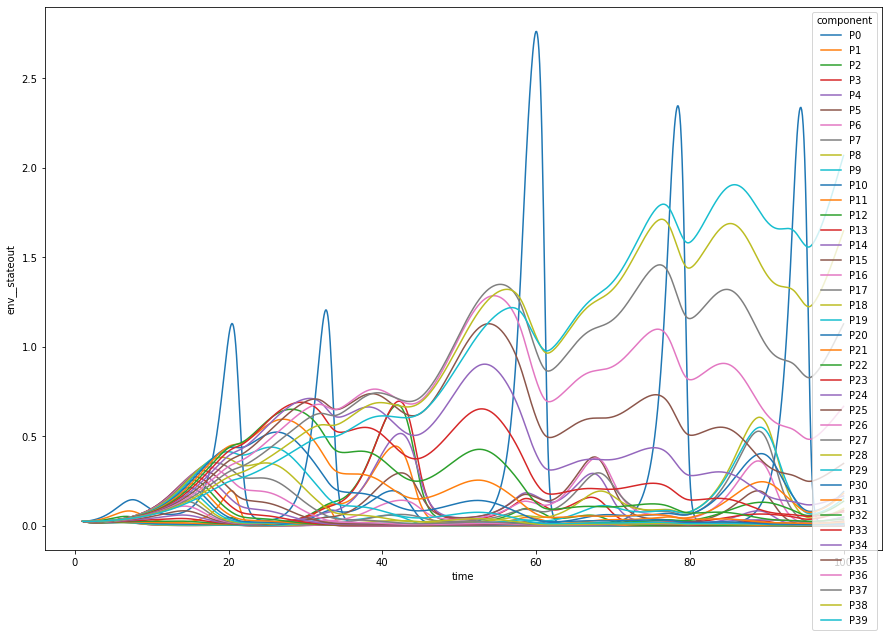

In [949]:
mom_out2.env__stateout[:,0:40].plot.line(x='time')

plt.savefig('output_P.pdf', bbox_inches='tight')

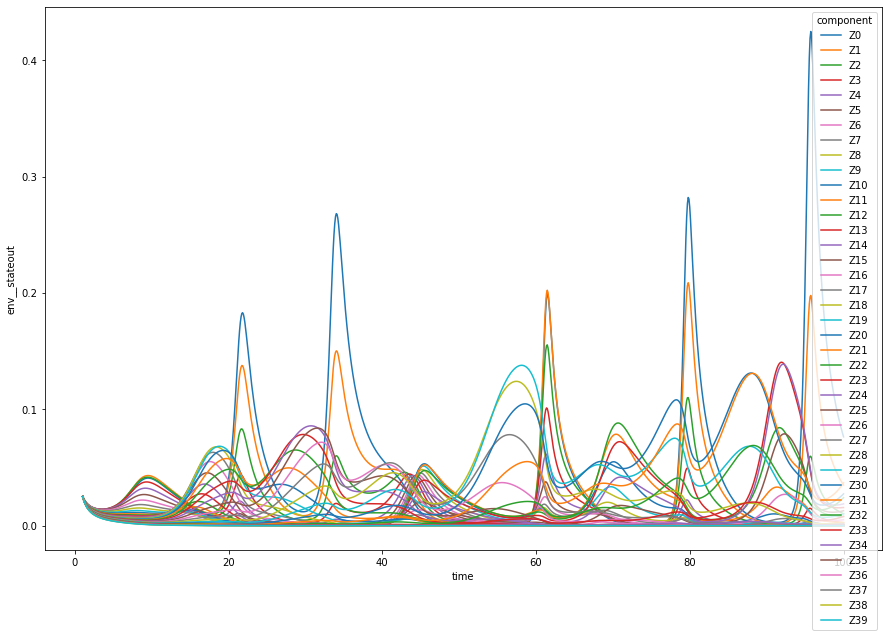

In [950]:
mom_out2.env__stateout[:,40:80].plot.line(x='time')


plt.savefig('output_Z.pdf', bbox_inches='tight')

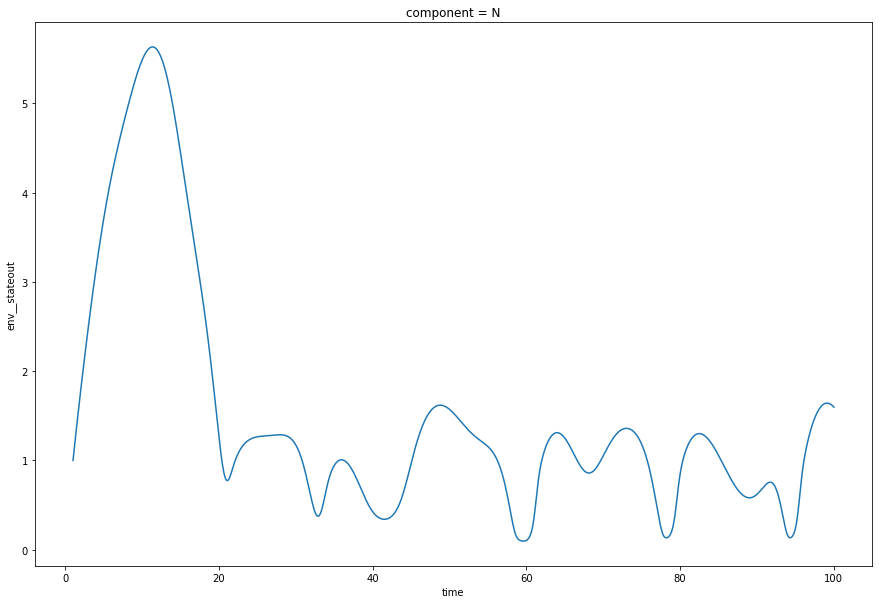

In [951]:
mom_out2.env__stateout[:,80].plot.line(x='time')


plt.savefig('output_N.pdf', bbox_inches='tight')

In [608]:
@xs.process
class ModelSolver:
    labels = xs.group('label')
    init = xs.group('init')
    
    fluxes = xs.group('flux')
 
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0
        self.state = {label: val for label, val in zip(self.labels, self.init)}
        self.stateout = [self.state[label] for label in self.labels]
        self.funcs = {label: flux for label, flux in zip(self.labels, self.fluxes)}
        
        self.component = [i for i in self.labels]


    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step by multiplying by dt
        self.outflux = {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.labels}
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.labels}
        self.stateout = [self.state[label] for label in self.labels]
        #print(self.state)

In [609]:
# This should be the ideal setup way:
flextestModelSetup = xs.Model({'MS':ChemostatParameters,
                               'N1':Nutrient, 
                               'P1':Phytoplankton, 'P2':Phytoplankton, 'P3':Phytoplankton, 
                               'ModelSolver':ModelSolver})

NameError: name 'ChemostatParameters' is not defined

In [610]:
#flextestModelSetup.all_vars_dict

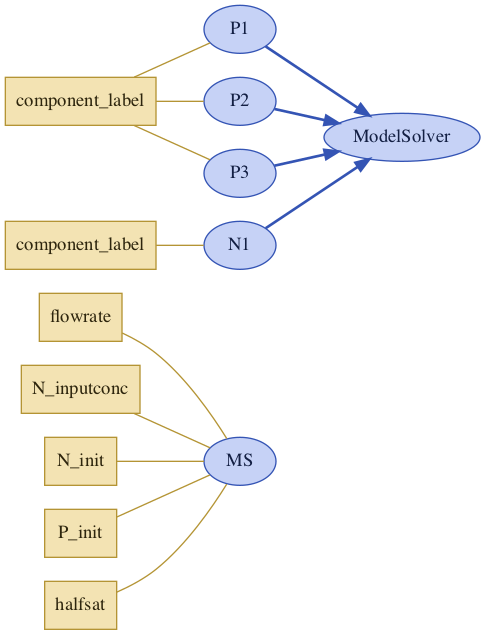

In [51]:
flextestModelSetup.visualize(show_inputs=True)

In [52]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('MS__N_init', value=1,  vary=False)
parameters.add('MS__P_init', value=0.1, vary=False)

parameters.add('MS__N_inputconc', value=2,  vary=False)
parameters.add('MS__flowrate', value=0.2,  vary=False)
parameters.add('MS__halfsat', value=0.5,  vary=False)

In [53]:
def parameterDict2Input_vars(params):
    params = {key : value for key, value in params.valuesdict().items()} 
    
    return params

In [54]:
parameterDict2Input_vars(parameters)

{'MS__N_init': 1,
 'MS__P_init': 0.1,
 'MS__N_inputconc': 2,
 'MS__flowrate': 0.2,
 'MS__halfsat': 0.5}

In [55]:
flextestModelSetup_in = xs.create_setup(
 model=flextestModelSetup,
    clocks={
         'time': np.linspace(0,20,1000)
     },
    
    input_vars = parameterDict2Input_vars(parameters),
    
    output_vars={
        'ModelSolver__component' : None,
        'ModelSolver__stateout'  : 'time',
        'ModelSolver__outflux': 'time'
    }
    
)

In [56]:
component_num = 1
out = flextestModelSetup_in.xsimlab.run(model=flextestModelSetup)

In [57]:
out2 = out.set_index(component='ModelSolver__component')

In [58]:
out2

<xarray.Dataset>
Dimensions:                (component: 4, time: 1000)
Coordinates:
  * time                   (time) float64 0.0 0.02002 0.04004 ... 19.98 20.0
  * component              (component) object 'N1' 'P2' 'P3' 'P4'
Data variables:
    P3__component_label    <U1 'P'
    P1__component_label    <U1 'P'
    N1__component_label    <U1 'N'
    P2__component_label    <U1 'P'
    MS__N_init             int64 1
    MS__P_init             float64 0.1
    MS__N_inputconc        int64 2
    MS__flowrate           float64 0.2
    MS__halfsat            float64 0.5
    ModelSolver__stateout  (time, component) float64 1.0 0.1 ... 0.6204 0.6204
    ModelSolver__outflux   (time) object {'N1': 0.0, 'P2': 0.0009342676009342675, 'P3': 0.0009342676009342675, 'P4': 0.0009342676009342675} ... {'N1': -4.753622309054897e-06, 'P2': 1.8627641981626635e-05, 'P3': 1.8627641981626635e-05, 'P4': 1.8627641981626635e-05}

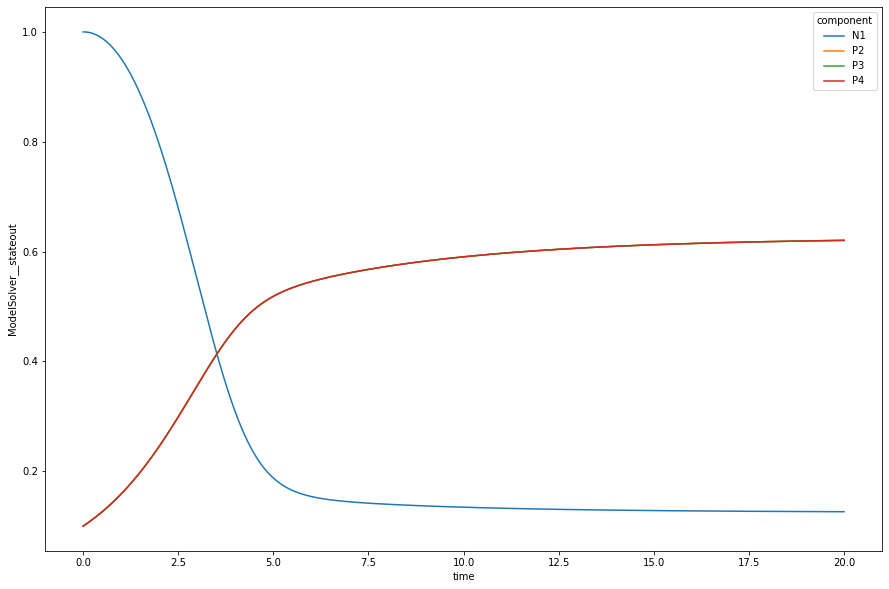

In [59]:
out2.ModelSolver__stateout.plot.line(x='time')